In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_data_path='/content/drive/MyDrive/bertm/bertm/train.csv'
train_data_path='/content/drive/MyDrive/bertm/bertm/test.csv'

In [ ]:
!pip install -q tensorflow-text==2.6.0

     |████████████████████████████████| 4.4 MB 9.8 MB/s 
     |████████████████████████████████| 463.8 MB 35 kB/s 
     |████████████████████████████████| 132 kB 29.9 MB/s 
     |████████████████████████████████| 1.3 MB 40.4 MB/s 
     |████████████████████████████████| 14.8 MB 41.5 MB/s 
     |████████████████████████████████| 462 kB 46.4 MB/s 
     |████████████████████████████████| 5.6 MB 40.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
#import shutil
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')



import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF","#FA8072","#FFBF00","#DE3163","#CCCCFF",
                        "#6495ED","#40E0D0","#8E6B63","#8E6B63","#FFA07A","#58D68D","#BFC9CA","#884EA0","#138D75","#E67E22",
                        "#1E8449","#F39C12","#34495E","#5DADE2","#E8DAEF","#FAD7A0","#B7950B","#641E16","#F9EBEA","#F39C12",
                        "#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF","#FA8072","#FFBF00","#DE3163","#CCCCFF",
                        "#6495ED","#40E0D0","#8E6B63","#8E6B63","#FFA07A","#58D68D","#BFC9CA","#884EA0","#138D75","#E67E22",
                        "#1E8449","#F39C12","#34495E","#5DADE2","#E8DAEF","#FAD7A0","#B7950B","#641E16","#F9EBEA","#F39C12",
                        "#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF","#FA8072","#FFBF00","#DE3163","#CCCCFF",
                        "#1E8449","#F39C12","#34495E","#5DADE2","#E8DAEF","#FAD7A0","#B7950B"
                        ]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 25, 5

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
traindf=pd.read_csv(train_data_path)
traindf.head()

,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival


In [ ]:
import random
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

traindf,validdf=train_test_split(traindf,.2)




In [ ]:
testdf=pd.read_csv(test_data_path)
testdf.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [ ]:
trainfeatures=traindf.copy()
trainlabels=trainfeatures.pop("category")
print(trainlabels)

1          card_arrival
2          card_arrival
3          card_arrival
4          card_arrival
5          card_arrival
             ...       
3073    country_support
3074    country_support
3075    country_support
3078    country_support
3079    country_support
Name: category, Length: 2464, dtype: object


In [ ]:
trainfeatures=trainfeatures.values
print(trainfeatures)

[['I still have not received my new card, I ordered over a week ago.']
 ['I ordered a card but it has not arrived. Help please!']
 ['Is there a way to know when my card will arrive?']
 ...
 ["If i'm not in the UK, can I still get a card?"]
 ['What are the countries you operate in.']
 ['Can the card be mailed and used in Europe?']]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


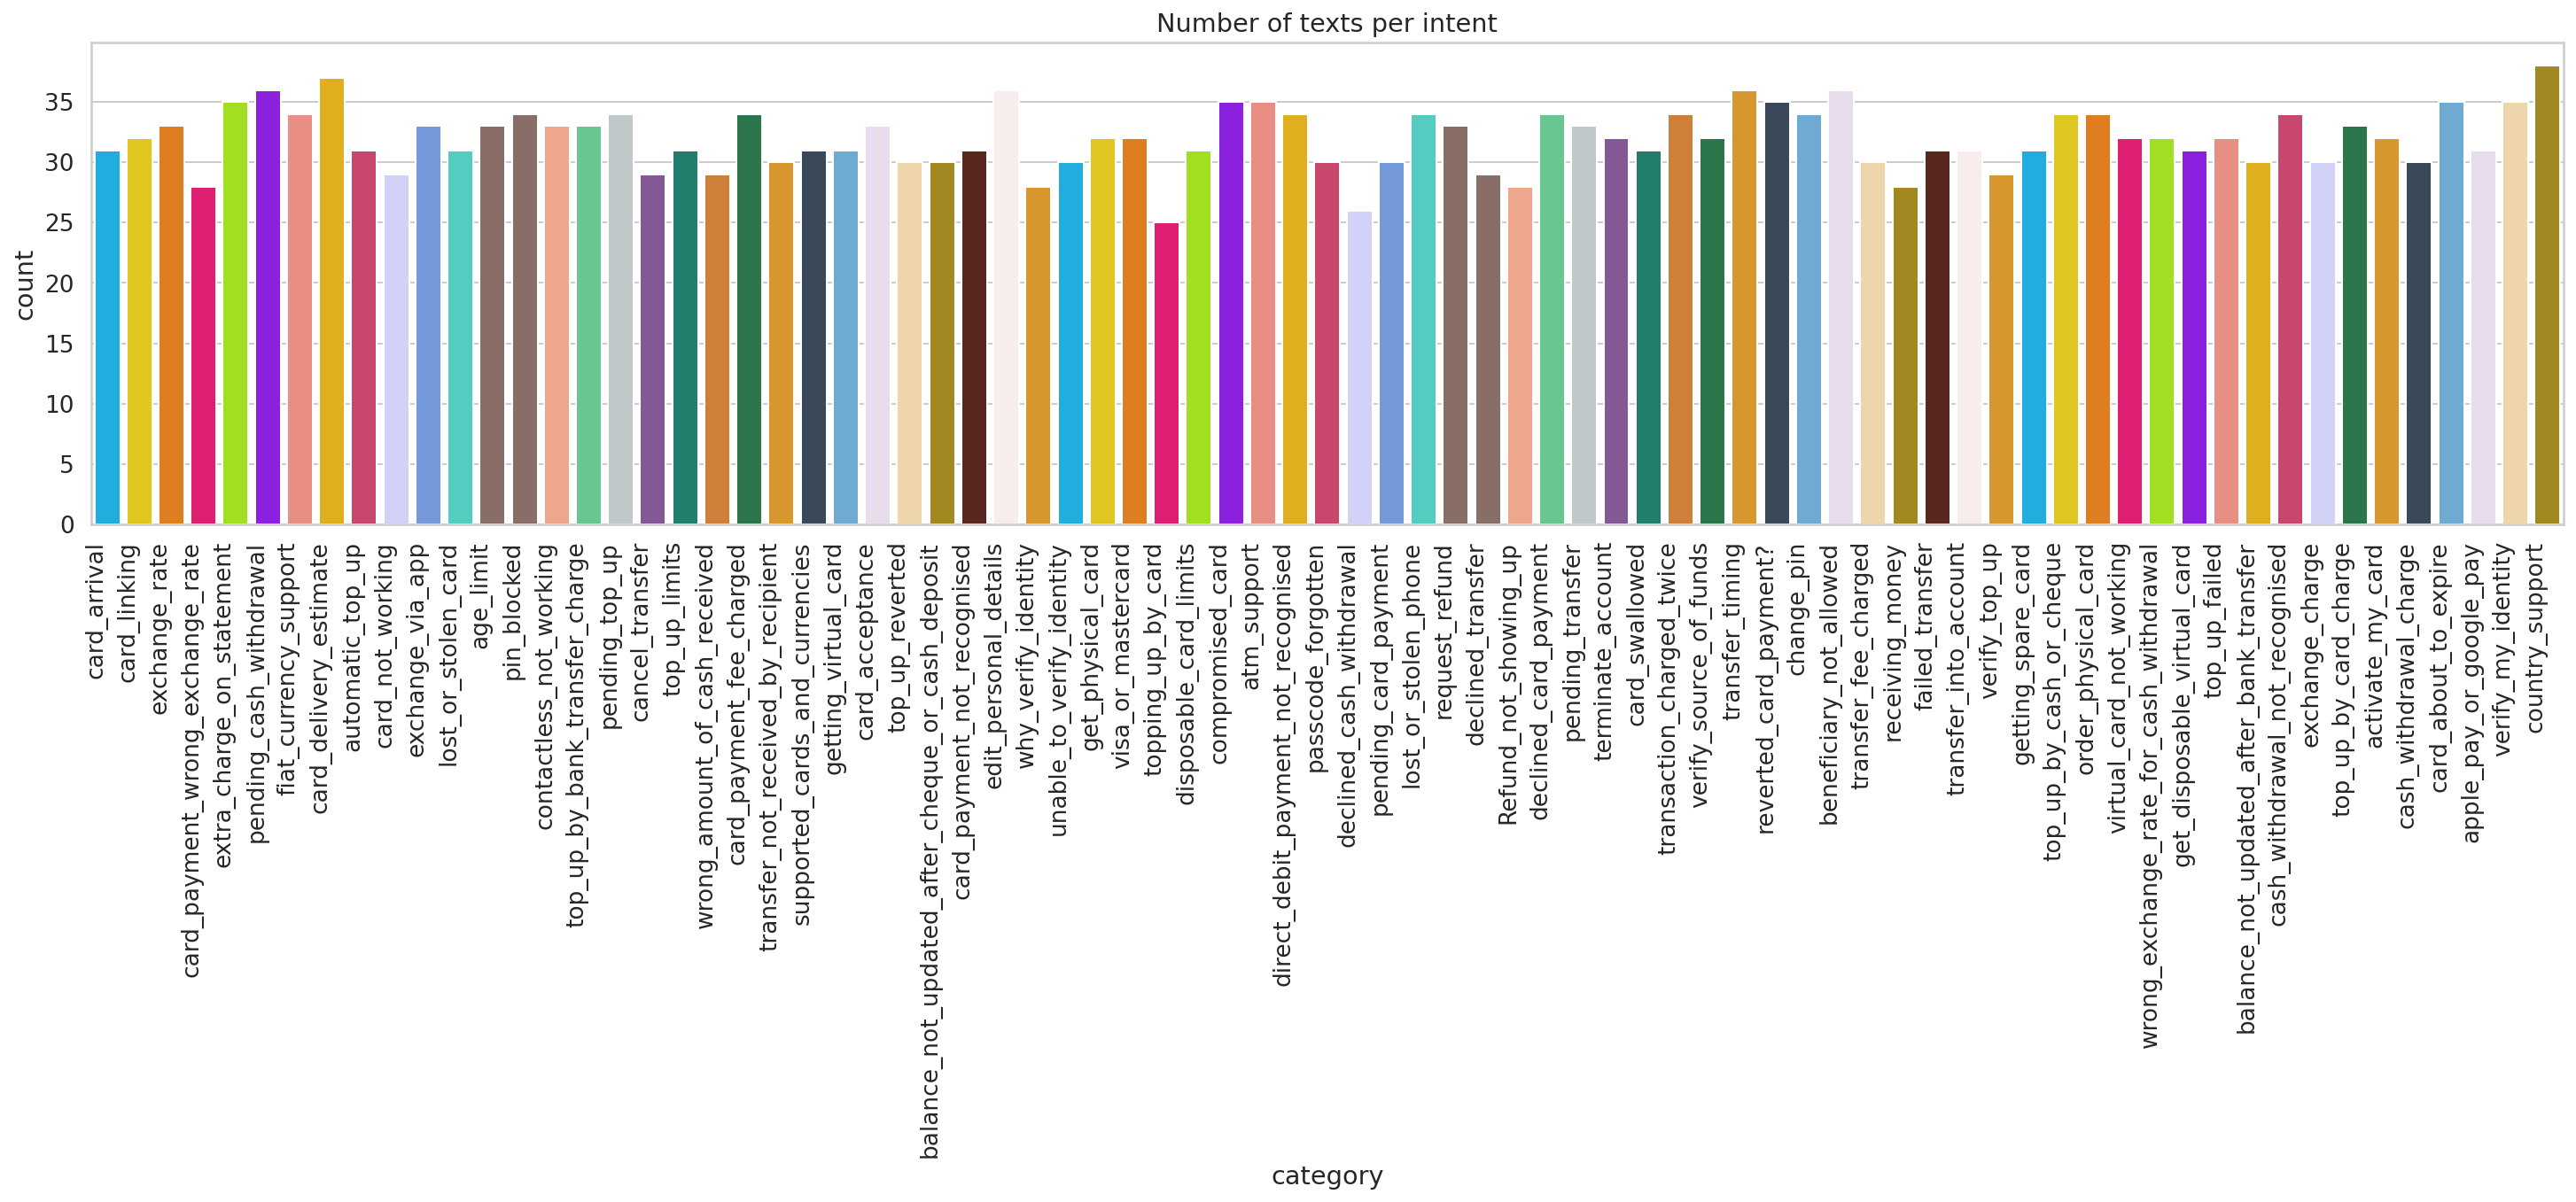

In [ ]:
chart = sns.countplot(traindf.category, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right');

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)

In [ ]:
trainlabels.shape

(2464, 77)

In [ ]:
testfeatures=testdf.copy()
testlabel=testfeatures.pop("category")
validfeatures=validdf.copy()
validlabel=validfeatures.pop("category")

testfeatures=testfeatures.values
validfeatures=validfeatures.values

testlabels=binarizer.transform(testlabel.values)
validlabels=binarizer.transform(validlabel.values)
print(type(testlabels))

<class 'numpy.ndarray'>


In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
trainfeatures[0]

array(['I still have not received my new card, I ordered over a week ago.'],
      dtype=object)

In [ ]:
text_test = trainfeatures[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2145 2031 2025 2363 2026 2047 4003 1010 1045 3641]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.49133193 -0.2838122  -0.9999492  -0.5472805  -0.3043772  -0.39749086
 -0.993474    0.18970734  0.59157413  0.32727003  0.13230531  0.1738093 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.21684386  0.02759144  0.49695584 ... -0.72569025 -1.2785803
  -0.87105596]
 [-0.7544034  -0.31706095  0.5162398  ... -0.20435505 -0.4788832
   0.17918459]
 [-0.61869746  0.23289928 -0.7676543  ...  0.06189113  1.1857712
  -0.42926407]
 ...
 [-0.5944572   0.7230724   0.0982886  ...  0.36071733  0.4253596
  -0.17990106]
 [-0.6242524   0.3052001   0.554699   ... -0.57939357 -0.5012429
  -0.28688762]
 [-0.08891459  0.49725685 -0.39650214 ...  0.05384841 -0.02772445
  -0.9776524 ]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(77, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result=classifier_model(tf.constant(trainfeatures[0]))
print(tf.keras.activations.softmax(bert_raw_result))
'''
for train in trainfeatures:
  bert_raw_result = classifier_model(tf.constant(train))
  print(bert_raw_result)
print(tf.keras.activations.softmax(bert_raw_result))
'''

tf.Tensor(
[[0.01116642 0.00389086 0.00923149 0.00194485 0.00572967 0.00329859
  0.02162452 0.00555847 0.08350154 0.0082433  0.00584865 0.00879434
  0.00436217 0.00545047 0.00284504 0.01251924 0.00149059 0.01908898
  0.00150751 0.03109566 0.00755893 0.00995524 0.00791681 0.01558596
  0.02582945 0.00476245 0.01959553 0.00395905 0.01324386 0.00324807
  0.02739565 0.01289119 0.01099951 0.00681978 0.03023648 0.00682577
  0.00739326 0.01617812 0.03733554 0.00944099 0.01718163 0.02684001
  0.00399433 0.00808681 0.00994895 0.0059782  0.00223327 0.00464379
  0.00100709 0.06657738 0.00609794 0.02168177 0.02232789 0.01864669
  0.00617367 0.05236479 0.00746349 0.00890996 0.0058512  0.00854014
  0.00796056 0.00593574 0.01780407 0.01121215 0.00702978 0.01085927
  0.0238551  0.00535746 0.00393232 0.0097658  0.00658347 0.00260295
  0.01704602 0.00702034 0.00960275 0.00997919 0.01454011]], shape=(1, 77), dtype=float32)


'\nfor train in trainfeatures:\n  bert_raw_result = classifier_model(tf.constant(train))\n  print(bert_raw_result)\nprint(tf.keras.activations.softmax(bert_raw_result))\n'

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 5 41373185    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
epochs=10
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
'''print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=trainfeatures,y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               epochs=epochs)'''

"print(f'Training model with {tfhub_handle_encoder}')\nhistory = classifier_model.fit(x=trainfeatures,y=trainlabels,\n                               validation_data=(validfeatures,validlabels),\n                               batch_size=32,\n                               epochs=epochs)"

In [ ]:
'''history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')'''

'history_dict = history.history\nprint(history_dict.keys())\n\nacc = history_dict[\'categorical_accuracy\']\nval_acc = history_dict[\'val_categorical_accuracy\']\nloss = history_dict[\'loss\']\nval_loss = history_dict[\'val_loss\']\n\nepochs = range(1, len(acc) + 1)\nfig = plt.figure(figsize=(10, 8))\nfig.tight_layout()\n\nplt.subplot(2, 1, 1)\n# "bo" is for "blue dot"\nplt.plot(epochs, loss, \'r\', label=\'Training loss\')\n# b is for "solid blue line"\nplt.plot(epochs, val_loss, \'b\', label=\'Validation loss\')\nplt.title(\'Training and validation loss\')\nplt.grid(True)\n# plt.xlabel(\'Epochs\')\nplt.ylabel(\'Loss\')\nplt.legend()\n\nplt.subplot(2, 1, 2)\nplt.plot(epochs, acc, \'r\', label=\'Training acc\')\nplt.plot(epochs, val_acc, \'b\', label=\'Validation acc\')\nplt.title(\'Training and validation accuracy\')\nplt.grid(True)\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Accuracy\')\nplt.legend(loc=\'lower right\')'

In [ ]:
#binarizer.classes_

In [ ]:
#classifier_model.save('/content/drive/MyDrive/k2')

In [ ]:
from tensorflow import keras
classifier_model = keras.models.load_model('/content/drive/MyDrive/k1')

In [ ]:
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 80s 253ms/step - loss: 1.0622 - categorical_accuracy: 0.7821
Loss: 1.06222403049469
Accuracy: 0.7820653915405273


In [ ]:
#f=open("/content/drive/MyDrive/BERT_FOR_INTENTCLASSIFICATION/New_out.txt","w")
import math
predicting_labels_after_thresh=list()
inaccuracy=1-accuracy
no_miss_class=math.ceil(len(testfeatures)*inaccuracy)
#print(no_miss_class)
threshold_values=[5]
index_list=list()
import torch
for thres_val in threshold_values:
  no_of_rejection=0
  correct=0
  correct1=0
  for i in range(len(testfeatures)):
    results=classifier_model(tf.constant(testfeatures[i]))#[12,13,18,10,9]
    array=results.numpy()#numpy
    previous_class=binarizer.inverse_transform(array)#dog
    t= torch.from_numpy(array)
    k=torch.threshold(t,thres_val,0.0)
    array=k.numpy()
    r=tf.convert_to_tensor(array, dtype=tf.float32)
    #print(r.numpy())
    if tf.math.count_nonzero(r)==0:#[0,0,0,0,0]
      no_of_rejection+=1
      results = binarizer.inverse_transform(r.numpy())
      #print(results[0],previous_class[0],testlabel[i])
      #print("hjfjd")
      index_list.append(i)
      if previous_class[0]==testlabel[i]:
        
        correct=correct+1
      #print(results)
      predicting_labels_after_thresh.append(results)

    else:
      results = binarizer.inverse_transform(r.numpy())
      if results[0]==testlabel[i]:
        correct1+=1
      predicting_labels_after_thresh.append(results)
  print("*****************************************************")
  print("Threshold value   :",thres_val,"\nNo of Rejection   :",no_of_rejection,"\nRejection Ratio   :",(no_of_rejection/len(testfeatures)),"\nAccuracy of Rejected Point  :",correct/no_of_rejection,"\nAccuracy of Non-Rejected Point  :",correct1/(len(testlabel)-no_of_rejection))
  print("*****************************************************")

*****************************************************
Threshold value   : 5 
No of Rejection   : 4193 
Rejection Ratio   : 0.4191742477256823 
Accuracy of Rejected Point  : 0.577152396851896 
Accuracy of Non-Rejected Point  : 0.9299483648881239
*****************************************************


In [ ]:
print("Number of rejections:",len(index_list))
dat= pd.DataFrame(index_list, columns = ['index'])
testdf['index'] = testdf.index
#print(dat)
rejection_sample=pd.merge(testdf, dat, how="inner", on="index")          # Using drop() function
#traindata=traindf
rejection_sample.info()

Number of rejections: 4193
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4193 entries, 0 to 4192
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      4193 non-null   object
 1   category  4193 non-null   object
 2   index     4193 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 131.0+ KB


In [ ]:
traindata=pd.read_csv(train_data_path)

In [ ]:
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# check for NaN values and remove them 
#traindata["text"].dropna(inplace=True)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
traindata.info()
# 1. Removing Blank Spaces
traindata['text'].dropna(inplace=True)
traindata['text_original'] = traindata['text']
# 3. Tokenization-In this each entry in the corpus will be broken into set of words
traindata['text']= [word_tokenize(str(entry)) for entry in traindata['text']]
# 4. Remove Stop words, Non-Numeric and perfoming Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

traindata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3080 non-null   object
 1   category  3080 non-null   object
dtypes: object(2)
memory usage: 48.2+ KB


,text,category,text_original
0,"[How, do, I, locate, my, card, ?]",card_arrival,How do I locate my card?
1,"[I, still, have, not, received, my, new, card,...",card_arrival,"I still have not received my new card, I order..."
2,"[I, ordered, a, card, but, it, has, not, arriv...",card_arrival,I ordered a card but it has not arrived. Help ...
3,"[Is, there, a, way, to, know, when, my, card, ...",card_arrival,Is there a way to know when my card will arrive?
4,"[My, card, has, not, arrived, yet, .]",card_arrival,My card has not arrived yet.


In [ ]:
#df=pd.read_csv('/content/drive/MyDrive/bertm/preprocessed_test_data.csv')


In [ ]:

for index,entry in enumerate(traindata['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(str(word_Final))
    # The final processed set of words for each iteration will be stored in 'text_final'
    traindata.loc[index,'text_final'] = str(Final_words)

In [ ]:
traindata.drop(['text'], axis=1)
output_path = '/content/drive/MyDrive/bertm/preprocessed_train_data_14.csv'
traindf.to_csv(output_path, index=False)
#traindata = traindata.dropna()
traindata = traindata[traindata['text_final'].notna()]

In [ ]:
Train_X=traindata['text_final']
Train_Y=traindata['category']
Test_X=rejection_sample['text']
Test_Y=rejection_sample['category']


In [ ]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)


In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(traindata['text_final'])
Train_X_Tfidf= Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
print(Tfidf_vect.vocabulary_)

{'how': 443, 'locate': 520, 'card': 147, 'still': 879, 'receive': 726, 'new': 593, 'order': 628, 'week': 1025, 'ago': 27, 'arrive': 69, 'help': 424, 'please': 673, 'is': 486, 'way': 1022, 'know': 500, 'my': 584, 'yet': 1059, 'when': 1030, 'get': 402, 'do': 266, 'tracking': 950, 'number': 605, 'send': 816, 'wait': 1017, 'normal': 599, 'track': 949, 'long': 526, 'delivery': 237, 'take': 912, 'what': 1028, 'ok': 616, 'longer': 527, 'expect': 328, 'bank': 103, 'could': 203, 'provide': 700, 'information': 470, 'why': 1036, 'deliver': 236, 'where': 1031, 'lose': 531, 'status': 874, 'mail': 537, 'think': 927, 'something': 856, 'go': 405, 'wrong': 1055, 'want': 1019, 'wonder': 1047, 'does': 269, 'it': 490, 'two': 967, 'start': 869, 'info': 468, 'available': 92, 'wo': 1046, 'show': 833, 'app': 54, 'would': 1054, 'like': 511, 'reactivate': 716, 'link': 513, 'put': 705, 'already': 34, 'see': 809, 'anywhere': 53, 'add': 20, 'account': 9, 'can': 138, 'old': 618, 'back': 99, 'system': 911, 'find': 3

In [ ]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  47.69854519437157
